In [2]:
import pandas as pd # 0.21.0
import numpy as np
from functools import reduce
from time import time

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [3]:
np.random.seed(203)

In [4]:
#https://qiita.com/ynakayama/items/897cc932008bd5c0e452
#http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
#file:///home/tasuku/Downloads/Report.pdf
#http://ta-lib.org/d_api/ta_setunstableperiod.html

In [5]:
import talib as ta
ta.get_function_groups

<function talib.get_function_groups>

In [6]:
np.random.seed(100)
quandl.ApiConfig.api_key = "eFys5fhhsTNVrsJEcQ5y"

In [7]:
df = quandl.get("WIKI/"+"AAPL", start_date="10-01-09", end_date="17-10-17")
df.head(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-11,212.80,213.00,208.45,210.11,16508200.0,0.0,1.0,27.347766,27.373469,26.788730,27.002063,115557400.0
2010-01-12,209.19,209.77,206.42,207.72,21230700.0,0.0,1.0,26.883831,26.958369,26.527847,26.694915,148614900.0
2010-01-13,207.87,210.93,204.10,210.65,21639000.0,0.0,1.0,26.714192,27.107445,26.229695,27.071461,151473000.0


In [8]:
df.loc['2010-05-13']

Open           2.632200e+02
High           2.650000e+02
Low            2.564000e+02
Close          2.583600e+02
Volume         2.141830e+07
Ex-Dividend    0.000000e+00
Split Ratio    1.000000e+00
Adj. Open      3.382744e+01
Adj. High      3.405619e+01
Adj. Low       3.295097e+01
Adj. Close     3.320286e+01
Adj. Volume    1.499281e+08
Name: 2010-05-13 00:00:00, dtype: float64

In [9]:
df.shift(1).dropna().head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-12,212.80,213.00,208.45,210.11,16508200.0,0.0,1.0,27.347766,27.373469,26.788730,27.002063,115557400.0
2010-01-13,209.19,209.77,206.42,207.72,21230700.0,0.0,1.0,26.883831,26.958369,26.527847,26.694915,148614900.0
2010-01-14,207.87,210.93,204.10,210.65,21639000.0,0.0,1.0,26.714192,27.107445,26.229695,27.071461,151473000.0
2010-01-15,210.11,210.46,209.02,209.43,15460500.0,0.0,1.0,27.002063,27.047043,26.861983,26.914674,108223500.0
2010-01-19,210.93,211.60,205.87,205.93,21216700.0,0.0,1.0,27.107445,27.193549,26.457164,26.464875,148516900.0


In [10]:
def get_features(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    log_ret_df = get_log_returns(df['Adj. Close'])
    # Handle look ahead-bias
    shifted_df = df.shift(1)
    momentum_df = get_momentum_indicators(shifted_df)
    hist_vol_df = get_hist_vol_indicators(shifted_df)
    pattern_df = get_pattern_recognition_indicators(shifted_df)
    dfs = [shifted_df, log_ret_df,momentum_df, hist_vol_df, pattern_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs).dropna()
    return df_final

def get_log_returns(df):
    df_log =  pd.DataFrame(np.log(df/df.shift(1))).dropna()
    df_log = df_log.rename(index=str, columns={"Adj. Close": "log_ret"})
    return df_log

def get_momentum_indicators(df):
    # http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    momentum = dict()
    days = [7,14,28]
    for t in days:
        momentum['adx_{}'.format(t)] = ta.ADX(high, low, close, timeperiod=t)
        momentum['adxr_{}'.format(t)] = ta.ADXR(high, low, close, timeperiod=t)
        momentum['aroondown_{}'.format(t)], momentum['aroonup_{}'.format(t)] = ta.AROON(high, low, timeperiod=t)
        momentum['aroon_{}'.format(t)] = ta.AROONOSC(high, low, timeperiod=t)
        momentum['rsi_{}'.format(t)] = ta.RSI(close, timeperiod=t)
        momentum['mom_{}'.format(t)] = ta.MOM(close, timeperiod=t)
        momentum['roc_{}'.format(t)] = ta.ROC(close, timeperiod=t)
        momentum['willr_{}'.format(t)] = ta.WILLR(high, low, close, timeperiod=t)
        momentum['trix_{}'.format(t)] = ta.TRIX(close, timeperiod=t)
        
        
    momentum['apo'] = ta.APO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['macd'], momentum['macdsignal'], momentum['macdhist'] = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    momentum['ppo'] = ta.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    momentum['slowk'], momentum['slowd'] = ta.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    momentum['fastk'], momentum['fastd'] = ta.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    momentum['fastkrsi'], momentum['fastdrsi'] = ta.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    
    
    df = pd.DataFrame.from_dict(momentum)
    df = df.set_index(df_index)
    return df

def get_hist_vol_indicators(df):
    df_index = df.index
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    hist_vol = dict()
    days = [7,14,28]
    for t in days:
        hist_vol['atr_{}'.format(t)] = ta.ATR(high, low, close, timeperiod=t)
        hist_vol['natr_{}'.format(t)] = ta.NATR(high, low, close, timeperiod=t)
        
    hist_vol['trange'] = ta.TRANGE(high, low, close)
    df = pd.DataFrame.from_dict(hist_vol)
    df = df.set_index(df_index)
    return df

def get_pattern_recognition_indicators(df):
    df_index = df.index
    open = np.array(df['Adj. Open'], dtype='f8') 
    high = np.array(df['Adj. High'], dtype='f8') 
    low = np.array(df['Adj. Low'], dtype='f8')
    close = np.array(df['Adj. Close'], dtype='f8')
    
    patterns = dict()
    patterns['CDL2CROWS'] = ta.CDL2CROWS(open, high, low, close)
    patterns['CDL3BLACKCROWS'] = ta.CDL3BLACKCROWS(open, high, low, close)
    patterns['CDL3INSIDE'] = ta.CDL3INSIDE(open, high, low, close)
    patterns['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(open, high, low, close)
    patterns['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(open, high, low, close)
    patterns['CDL3STARSINSOUTH'] = ta.CDL3STARSINSOUTH(open, high, low, close)
    patterns['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(open, high, low, close)
    patterns['CDLABANDONEDBABY'] = ta.CDLABANDONEDBABY(open, high, low, close, penetration=0)
    patterns['CDLADVANCEBLOCK'] = ta.CDLADVANCEBLOCK(open, high, low, close)
    patterns['CDLBELTHOLD'] = ta.CDLBELTHOLD(open, high, low, close)
    patterns['CDLBREAKAWAY'] = ta.CDLBREAKAWAY(open, high, low, close)
    patterns['CDLCLOSINGMARUBOZU'] = ta.CDLCLOSINGMARUBOZU(open, high, low, close)
    patterns['CDLCONCEALBABYSWALL'] = ta.CDLCONCEALBABYSWALL(open, high, low, close)
    patterns['CDLCOUNTERATTACK'] = ta.CDLCOUNTERATTACK(open, high, low, close)
    patterns['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
    patterns['CDLDOJI'] = ta.CDLDOJI(open, high, low, close)
    patterns['CDLDOJISTAR'] = ta.CDLDOJISTAR(open, high, low, close)
    patterns['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(open, high, low, close)
    patterns['CDLENGULFING'] = ta.CDLENGULFING(open, high, low, close)
    patterns['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLGAPSIDESIDEWHITE'] = ta.CDLGAPSIDESIDEWHITE(open, high, low, close)
    patterns['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(open, high, low, close)
    patterns['CDLHAMMER'] = ta.CDLHAMMER(open, high, low, close)
    patterns['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(open, high, low, close)
    patterns['CDLHARAMI'] = ta.CDLHARAMI(open, high, low, close)
    patterns['CDLHARAMICROSS'] = ta.CDLHARAMICROSS(open, high, low, close)
    patterns['CDLHIGHWAVE'] = ta.CDLHIGHWAVE(open, high, low, close)
    patterns['CDLHIKKAKE'] = ta.CDLHIKKAKE(open, high, low, close)
    patterns['CDLHIKKAKEMOD'] = ta.CDLHIKKAKEMOD(open, high, low, close)
    patterns['CDLHOMINGPIGEON'] = ta.CDLHOMINGPIGEON(open, high, low, close)
    patterns['CDLIDENTICAL3CROWS'] = ta.CDLIDENTICAL3CROWS(open, high, low, close)
    patterns['CDLINNECK'] = ta.CDLINNECK(open, high, low, close)
    patterns['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(open, high, low, close)
    patterns['CDLKICKING'] = ta.CDLKICKING(open, high, low, close)
    patterns['CDLKICKINGBYLENGTH'] = ta.CDLKICKINGBYLENGTH(open, high, low, close)
    patterns['CDLLADDERBOTTOM'] = ta.CDLLADDERBOTTOM(open, high, low, close)
    patterns['CDLLONGLEGGEDDOJI'] = ta.CDLLONGLEGGEDDOJI(open, high, low, close)
    patterns['CDLLONGLINE'] = ta.CDLLONGLINE(open, high, low, close)
    patterns['CDLMARUBOZU'] = ta.CDLMARUBOZU(open, high, low, close)
    patterns['CDLMATCHINGLOW'] = ta.CDLMATCHINGLOW(open, high, low, close)
    patterns['CDLMATHOLD'] = ta.CDLMATHOLD(open, high, low, close, penetration=0)
    patterns['CDLMORNINGDOJISTAR'] = ta.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
    patterns['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(open, high, low, close, penetration=0)
    patterns['CDLONNECK'] = ta.CDLONNECK(open, high, low, close)
    patterns['CDLPIERCING'] = ta.CDLPIERCING(open, high, low, close)
    patterns['CDLRICKSHAWMAN'] = ta.CDLRICKSHAWMAN(open, high, low, close)
    patterns['CDLRISEFALL3METHODS'] = ta.CDLRISEFALL3METHODS(open, high, low, close)
    patterns['CDLSEPARATINGLINE'] = ta.CDLSEPARATINGLINES(open, high, low, close)
    patterns['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(open, high, low, close)
    patterns['CDLSHORTLINE'] = ta.CDLSHORTLINE(open, high, low, close)
    patterns['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(open, high, low, close)
    patterns['CDLSTALLEDPATTERN'] = ta.CDLSTALLEDPATTERN(open, high, low, close)
    patterns['CDLSTICKSANDWICH'] = ta.CDLSTICKSANDWICH(open, high, low, close)
    patterns['CDLTAKURI'] = ta.CDLTAKURI(open, high, low, close)
    patterns['CDLTASUKIGAP'] = ta.CDLTASUKIGAP(open, high, low, close)
    patterns['CDLTHRUSTING'] = ta.CDLTHRUSTING(open, high, low, close)
    patterns['CDLTRISTAR'] = ta.CDLTRISTAR(open, high, low, close)
    patterns['CDLUNIQUE3RIVER'] = ta.CDLUNIQUE3RIVER(open, high, low, close)
    patterns['CDLUPSIDEGAP2CROWS'] = ta.CDLUPSIDEGAP2CROWS(open, high, low, close)
    patterns['DLXSIDEGAP3METHODS'] = ta.CDLXSIDEGAP3METHODS(open, high, low, close)
    df = pd.DataFrame.from_dict(patterns)
    df = df.set_index(df_index)
    return df

In [11]:
df = get_features("AAPL", "09-01-09", "17-10-17")

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [12]:
print("Any Nans: {}".format(df.isnull().values.any()))
print("Nan count: {}".format(df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [13]:
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Ex-Dividend']
del df['Split Ratio']



In [14]:
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df[numerical_features]
train_cat = df[categorical_features]

Numerical features : 116
Categorical features : 0


### Date, Time features

In [15]:
df['Date'] = df.index
#df[['year','month','day']] = df.Date.str.split('-',expand=True)
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,DLXSIDEGAP3METHODS,Date,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-11,16713000.0,16.583439,16.865424,16.226170,16.602716,116991000.0,0.002937,44.442148,26.325859,48.684727,...,0,0,0,0,0,0,0,2009-05-11,5,11
2009-05-12,14452100.0,16.368820,16.830185,16.336692,16.651551,101164700.0,-0.040558,43.374433,26.498747,42.731371,...,0,0,0,0,0,0,0,2009-05-12,5,12
2009-05-13,21767200.0,16.650266,16.669543,15.839343,15.989704,152370400.0,-0.040430,40.844949,26.290780,40.656313,...,0,0,0,0,0,0,0,2009-05-13,5,13


In [16]:
del df['Date']
df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,DLXSIDEGAP3METHODS,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2009-05-11,16713000.0,16.583439,16.865424,16.226170,16.602716,116991000.0,0.002937,44.442148,26.325859,48.684727,...,0,0,0,0,0,0,0,0,5,11
2009-05-12,14452100.0,16.368820,16.830185,16.336692,16.651551,101164700.0,-0.040558,43.374433,26.498747,42.731371,...,0,0,0,0,0,0,0,0,5,12
2009-05-13,21767200.0,16.650266,16.669543,15.839343,15.989704,152370400.0,-0.040430,40.844949,26.290780,40.656313,...,0,0,0,0,0,0,0,0,5,13


### Create lagged features

In [17]:
steps = 20
lags_df = (pd.concat(
    [df.log_ret.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_ret'] + ['log_ret_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict current steering.
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_ret'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [18]:

final_df.head(3)

,Volume,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,log_ret,adx_14,adx_28,adx_7,...,log_ret_L10,log_ret_L11,log_ret_L12,log_ret_L13,log_ret_L14,log_ret_L15,log_ret_L16,log_ret_L17,log_ret_L18,log_ret_L19
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-08,22597000.0,18.674360,18.814440,18.404481,18.592111,158179000.0,-0.005684,33.954642,26.480935,52.193474,...,-0.013621,-0.013518,-0.012475,0.006297,0.033970,-0.004320,0.028545,-0.040430,-0.040558,0.002937
2009-06-09,33273300.0,18.482875,18.535565,17.918698,18.486730,232913100.0,-0.007886,34.108213,26.717750,49.721977,...,0.065405,-0.013621,-0.013518,-0.012475,0.006297,0.033970,-0.004320,0.028545,-0.040430,-0.040558
2009-06-10,24177300.0,18.481589,18.577975,18.062634,18.341509,169241100.0,-0.017458,34.304771,26.960771,47.818925,...,0.017208,0.065405,-0.013621,-0.013518,-0.012475,0.006297,0.033970,-0.004320,0.028545,-0.040430


In [19]:
print("Any Nans: {}".format(final_df.isnull().values.any()))
print("Nan count: {}".format(final_df.isnull().sum().sum()))

Any Nans: False
Nan count: 0


In [20]:
# Convert return into binary to format for classification
final_df["y"] = final_df.apply(lambda x: 1 if x['log_ret'] > 0 else 0 , axis=1)


In [549]:
# Remove log_ret which can lead to look ahead effects
del final_df["log_ret"]

In [550]:
print("shape: {}".format(final_df.shape))


shape: (2106, 137)


In [551]:
train_size = int(X.shape[0]*0.9)

### Split into train and test

In [552]:
train, test = final_df.iloc[:train_size], final_df.iloc[train_size:]
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (1895, 137)
Test shape: (211, 137)


In [553]:
train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)
train_dummy = pd.read_csv('train_data.csv')

In [554]:
train.head().T

Date,2009-06-08 00:00:00,2009-06-09 00:00:00,2009-06-10 00:00:00,2009-06-11 00:00:00,2009-06-12 00:00:00
Volume,2.259700e+07,3.327330e+07,2.417730e+07,2.459370e+07,1.874370e+07
Adj. Open,1.867436e+01,1.848287e+01,1.848159e+01,1.828496e+01,1.793412e+01
Adj. High,1.881444e+01,1.853557e+01,1.857797e+01,1.829396e+01,1.819243e+01
Adj. Low,1.840448e+01,1.791870e+01,1.806263e+01,1.777348e+01,1.780561e+01
Adj. Close,1.859211e+01,1.848673e+01,1.834151e+01,1.802408e+01,1.798553e+01
Adj. Volume,1.581790e+08,2.329131e+08,1.692411e+08,1.721559e+08,1.312059e+08
adx_14,3.395464e+01,3.410821e+01,3.430477e+01,3.370647e+01,3.315091e+01
adx_28,2.648094e+01,2.671775e+01,2.696077e+01,2.699674e+01,2.703142e+01
adx_7,5.219347e+01,4.972198e+01,4.781892e+01,4.315682e+01,3.916073e+01
adxr_14,3.297991e+01,3.248145e+01,3.196680e+01,3.068871e+01,2.952196e+01


In [555]:
train_temp = train[['Volume','Adj. Open']].iloc[0:3]
train_temp 

,Volume,Adj. Open
Date,,
2009-06-08,22597000.0,18.674360
2009-06-09,33273300.0,18.482875
2009-06-10,24177300.0,18.481589


In [556]:
mean_temp = train_temp.apply(np.mean,axis=0)
std_temp = train_temp.apply(np.std,axis=0)
(train_temp - mean_temp)/std_temp

,Volume,Adj. Open
Date,,
2009-06-08,-0.868372,1.41419
2009-06-09,1.400854,-0.70000
2009-06-10,-0.532482,-0.71419


In [557]:
(train_temp.Volume - np.mean(train_temp.Volume))/np.std(train_temp.Volume)

Date
2009-06-08   -0.868372
2009-06-09    1.400854
2009-06-10   -0.532482
Name: Volume, dtype: float64

In [558]:
mean = train.apply(np.mean,axis=0)
std = train.apply(np.std,axis=0)
norm = (train - mean)/std

In [559]:
norm.describe().T

,count,mean,std,min,25%,50%,75%,max
Volume,1895.0,0.000000e+00,1.000264,-1.110671,-0.696439,-0.318158,0.418647,8.275544
Adj. Open,1895.0,2.999653e-16,1.000264,-1.734124,-0.850099,-0.014223,0.846398,1.909703
Adj. High,1895.0,-2.399722e-16,1.000264,-1.734403,-0.854500,-0.013742,0.850379,1.876313
Adj. Low,1895.0,-5.999305e-17,1.000264,-1.736749,-0.844958,-0.010238,0.850765,1.869934
Adj. Close,1895.0,-5.999305e-17,1.000264,-1.739779,-0.848084,-0.013654,0.852874,1.868074
Adj. Volume,1895.0,5.999305e-17,1.000264,-1.438369,-0.763318,-0.194870,0.468309,6.278363
adx_14,1895.0,-1.274852e-16,1.000264,-1.725292,-0.748505,-0.185628,0.585006,4.016516
adx_28,1895.0,-9.373915e-17,1.000264,-1.657521,-0.763802,-0.199529,0.757181,3.651842
adx_7,1895.0,0.000000e+00,1.000264,-1.974197,-0.754883,-0.185569,0.577340,3.743537
adxr_14,1895.0,-1.312348e-16,1.000264,-1.616685,-0.733019,-0.120541,0.513878,3.994339


### Assess distribution and statistics of data

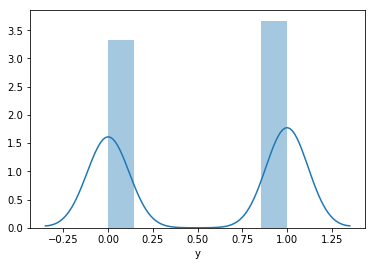

In [560]:
y_dummy = train_dummy.pop('y')
import seaborn as sns
%matplotlib inline
sns.distplot(y_dummy)

In [561]:
y_dummy.describe()

count    1895.000000
mean        0.524011
std         0.499555
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: y, dtype: float64

### Train RandomForest classifier

In [562]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred) * 100))


Accuracy for Random Forest Model: 45.97


In [563]:
import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):

    """
    Custom dataset to convert features to inputs of sequences.
    """

    def __init__(self, csv_file, root_dir, time_steps, transform=None):
        self._steps = time_steps
        self._transform = transform
        self._frames = pd.read_csv(os.path.join(root_dir, csv_file))
        
        self._y = self._frames.pop("y")
        self._X = self._frames

    def __len__(self):
        return len(self._frames.index) - self._steps

    def __getitem__(self, idx):
        index = idx + self._steps
        # Normalize over sequence (TODO: Find a better way to handle)
        X = self._X.iloc[index-self._steps:index]
        X_mean = X.apply(np.mean,axis=0)
        X_std = X.apply(np.std,axis=0)
        X_normalized = (X - X_mean)/(X_std+1e-10)
        sequence = torch.from_numpy(X_normalized.as_matrix())
        
        label = torch.from_numpy(np.array([self._y.iloc[index]]))
        return {'sequence': sequence, 'label': label}
    
    

In [576]:
train_data = SequenceDataset('train_data.csv','.',60)
test_data = SequenceDataset('test_data.csv','.',60)

train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)



In [1]:
class SimpleLSTM(nn.Module):
    
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.rnn = nn.LSTM(136, hidden_size=[4,50,100], num_layers=3, dropout=0.5, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(100, 2),
            nn.Sigmoid()
        )

    def forward(self, x, train=True):
        out, h = self.rnn(x)
        # We want the out of the last step (batch, step, out)
        return self.fc(out[:,-1,:])

NameError: name 'nn' is not defined

In [578]:
model = SimpleLSTM()
optimizer =  torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [579]:
model.train()
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = []
    for i, batch in enumerate(train_loader):
        inputs = batch['sequence']
        labels = batch['label']
        
        inputs, labels = Variable(inputs.type(torch.FloatTensor)), Variable(labels.type(torch.LongTensor).squeeze(1))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
        
        optimizer.step()
    

        # print statistics
        running_loss.append(loss.data[0])
    
    print('Epoch: {}  loss: {}'.format(
          epoch + 1, np.mean(np.array(running_loss))))


print('Finished Training')

Epoch: 1  loss: 0.6928679010198942
Epoch: 2  loss: 0.6923784432359222
Epoch: 3  loss: 0.6920042776281892
Epoch: 4  loss: 0.6915883617764923
Epoch: 5  loss: 0.6914851926652872
Epoch: 6  loss: 0.6908387988724566
Epoch: 7  loss: 0.6896179645522739
Epoch: 8  loss: 0.689441016551909
Epoch: 9  loss: 0.6885032674921956
Epoch: 10  loss: 0.691045847933039
Epoch: 11  loss: 0.6918209794756502
Epoch: 12  loss: 0.6925675530849426
Epoch: 13  loss: 0.6904765208345668
Epoch: 14  loss: 0.69083069160134
Epoch: 15  loss: 0.6833578008884306
Epoch: 16  loss: 0.6842358887845229
Epoch: 17  loss: 0.6786296924225965
Epoch: 18  loss: 0.6736248829059445
Epoch: 19  loss: 0.6759811315939277
Epoch: 20  loss: 0.669779493600861
Epoch: 21  loss: 0.6681188402123932
Epoch: 22  loss: 0.6668830833090749
Epoch: 23  loss: 0.6670020517926125
Epoch: 24  loss: 0.6627559284585698
Epoch: 25  loss: 0.6626255626899346
Epoch: 26  loss: 0.6613809139754532
Epoch: 27  loss: 0.6580679793611209
Epoch: 28  loss: 0.6581646370627899
Epoch:

In [580]:
def evaluate(model, loader):
    model.eval()
    loss_sum = 0
    acc_sum = 0
    for i, batch in enumerate(loader):
        inputs = batch['sequence']
        labels = batch['label']
        inputs = Variable(inputs.type(torch.FloatTensor), volatile=True)
        labels = Variable(labels.type(torch.LongTensor).squeeze(1), volatile=True)
        
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss_sum += loss.data[0]

        predict = output.data.max(1)[1]
        acc = predict.eq(labels.data).cpu().sum()
        acc_sum += acc
    return loss_sum / len(loader), acc_sum / len(loader)

In [581]:
print(evaluate(model, test_loader))

(0.6914129788117693, 0.5960264900662252)


In [207]:
score = Variable(torch.randn(10,2))
target = Variable((torch.rand(10)>0.5).long())
lfn1 = torch.nn.CrossEntropyLoss()
lfn2 = torch.nn.BCELoss()
print(lfn1(score,target), lfn2(torch.nn.functional.softmax(score)[:,1],target.float()))

Variable containing:
 0.8571
[torch.FloatTensor of size 1]
 Variable containing:
 0.8571
[torch.FloatTensor of size 1]



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [165]:
score

Variable containing:
-1.0032 -0.6803
 1.2381  0.0608
-0.8555  0.6880
 0.1313 -1.2839
-0.4654 -0.2737
-0.7864  0.7487
 1.4117  0.9339
 1.9578 -0.0274
-1.0772  2.5011
 0.2887 -0.4335
[torch.FloatTensor of size 10x2]

In [166]:
target

Variable containing:
 0
 1
 0
 1
 0
 1
 1
 0
 1
 1
[torch.LongTensor of size 10]